# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from matplotlib import pyplot as plt

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


In [48]:
df2 =df1.drop(['rest1','rest2','rest3','rest4'], axis = 1)
df2.head() 

,weekday,holiday,holiday_name,total
date,,,,
2016-01-01,Friday,1,New Year's Day,296
2016-01-02,Saturday,0,na,191
2016-01-03,Sunday,0,na,202
2016-01-04,Monday,0,na,105
2016-01-05,Tuesday,0,na,98


### Plot the source data

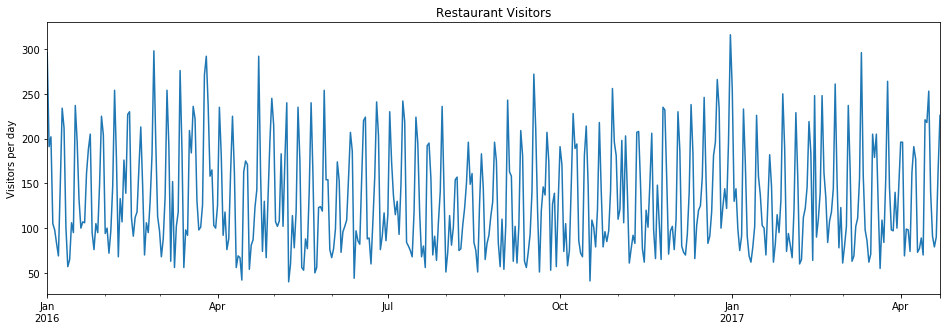

In [6]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at holidays
Rather than prepare a separate plot, we can use matplotlib to shade holidays behind our restaurant data.

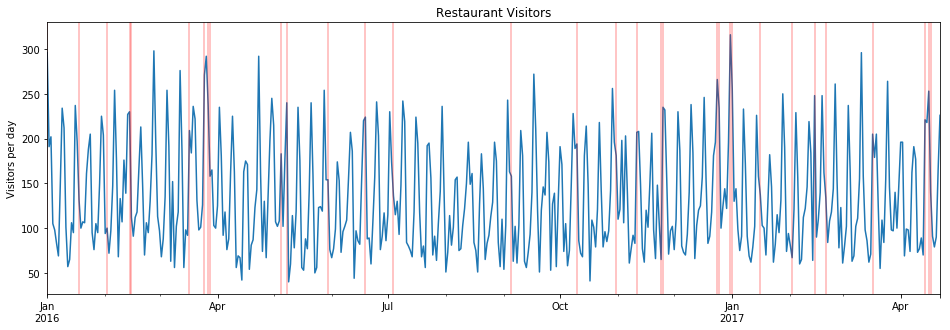

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.3);  # add a semi-transparent red line

### Run an ETS Decomposition

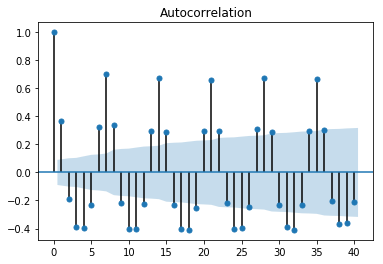

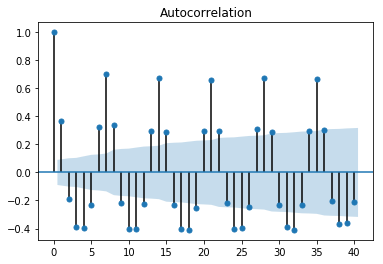

In [11]:
plot_acf(df1['total'],lags = 40)

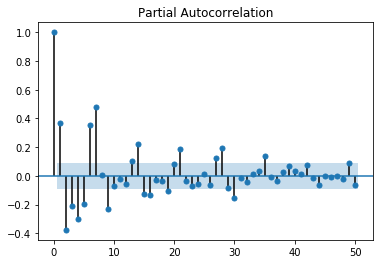

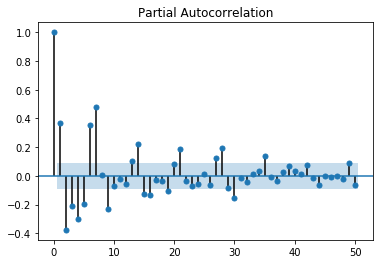

In [12]:
plot_pacf(df1['total'],lags = 50)

<Figure size 432x288 with 0 Axes>

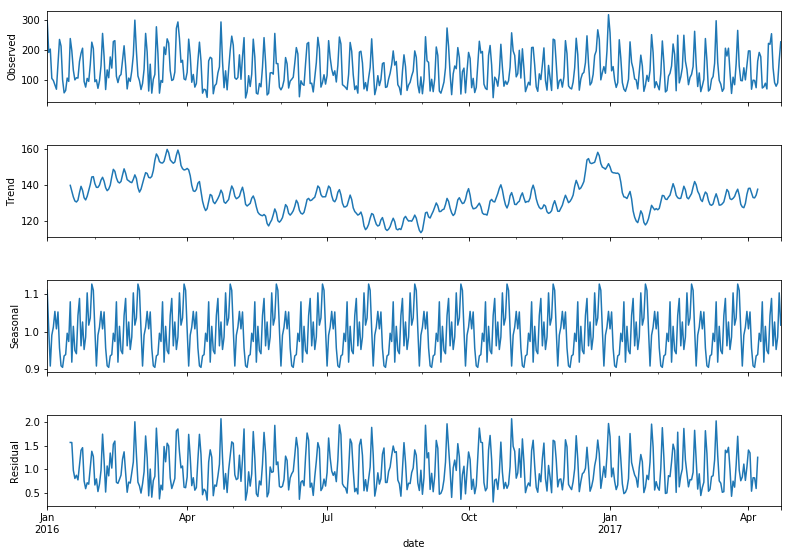

In [42]:
#result = seasonal_decompose(df1['total'])
#result.plot();

result = seasonal_decompose(df1['total'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 9)
fig.show()


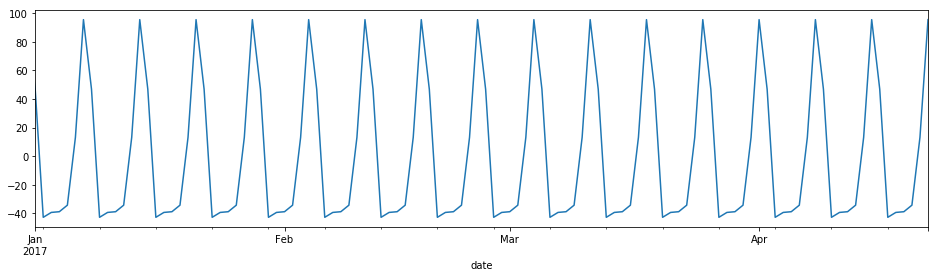

In [30]:
result.seasonal.plot(figsize = (16,4), xlim=('2017-01-01','2017-04-22'))
plt.show()

## Test for stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [44]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

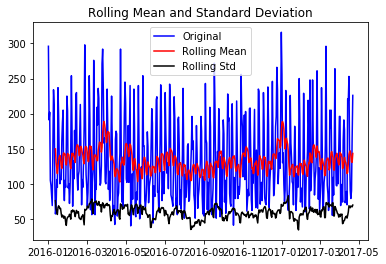

In [45]:
df_visit = df1['total']

test_stationarity(df_visit)


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [50]:
# For SARIMA Orders we set seasonal=True and pass in an m value
model_autoarima = auto_arima(df1['total'], seasonal=True,m=7)


In [51]:
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                  478
Model:             SARIMAX(1, 0, 1, 7)   Log Likelihood               -2386.975
Date:                 Mon, 13 Jan 2020   AIC                           4781.951
Time:                         22:38:13   BIC                           4798.629
Sample:                              0   HQIC                          4788.508
                                 - 478                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3862      1.715      2.557      0.011       1.024       7.748
ar.S.L7        0.9614      0.014     68.836      0.000       0.934       0.989
ma.S.L7       -0.7382      0.053    -13.893      0.000      -0.842      -0.634
sigma2      1330.2241     85.825     15.499      0.000    1162.010    1498.438
===================================================================================
Ljung-Box (Q):                       67.26   Jarque-Bera (JB):                66.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.75
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

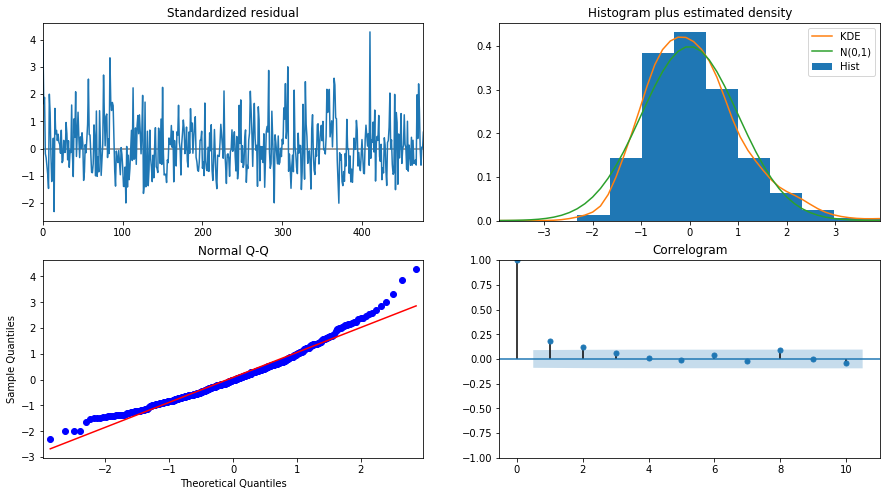

In [52]:
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()

Excellent! This provides an SARIMAX seasonal order of (1,0,1,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [83]:
len(df1)

478

In [84]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit a SARIMAX(1,0,1,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [85]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2155.511
Date:                           Mon, 13 Jan 2020   AIC                           4319.023
Time:                                   23:17:58   BIC                           4335.333
Sample:                               01-01-2016   HQIC                          4325.460
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2194      0.043      5.067      0.000       0.135       0.304
ar.S.L7        0.9999      0.000   8025.882      0.000       1.000       1.000
ma.S.L7       -0.9404      0.023    -40.025      0.000      -0.986      -0.894
sigma2      1068.8457     54.342     19.669      0.000     962.338    1175.354
===================================================================================
Ljung-Box (Q):                       30.74   Jarque-Bera (JB):               106.77
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

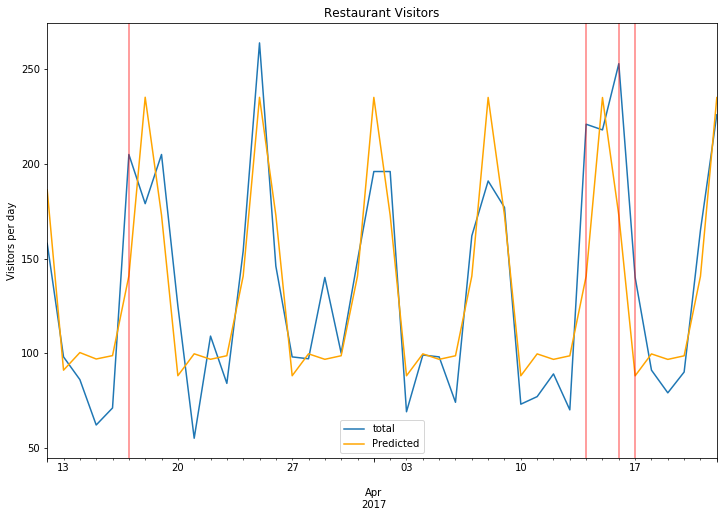

In [87]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

### Evaluate the Model

In [88]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error: 1022.142266
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.97095973


## Now add the exog variable

In [90]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2089.208
Date:                           Mon, 13 Jan 2020   AIC                           4188.417
Time:                                   23:18:31   BIC                           4208.805
Sample:                               01-01-2016   HQIC                          4196.463
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9350      3.773     18.271      0.000      61.540      76.330
ar.L1          0.2101      0.044      4.762      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3163     44.866     17.370      0.000     691.380     867.253
===================================================================================
Ljung-Box (Q):                       36.17   Jarque-Bera (JB):                20.47
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

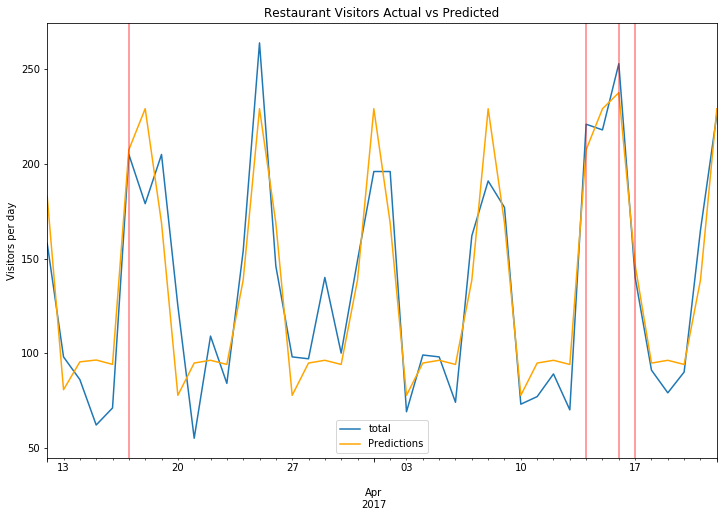

In [92]:
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [72]:

def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_pred - y_true) /np.abs(y_true))) * 100

In [94]:
mean_absolute_percentage_error(test['total'], predictions)

16.101476786912254

In [93]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(1,0,1,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(1,0,1,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error: 1022.142266
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.97095973

SARIMAX(1,0,0)(1,0,1,7) MSE Error: 525.7737459
SARIMAX(1,0,0)(1,0,1,7) RMSE Error: 22.92975678


### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [97]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('Forecast')

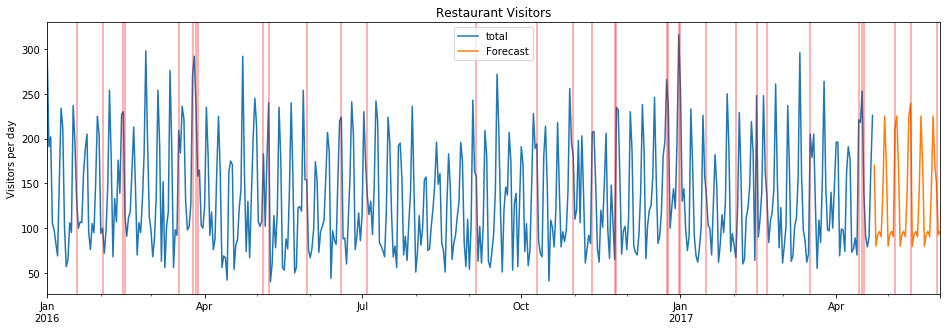

In [101]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,5),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.4);